### 데이터 불러오기

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SELECT_NORMAL = 2  
testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)
test_label = [2,4,6] # Define actual test class that we use
actual_testdata = torch.isin(testset.targets, torch.tensor(test_label)) 
testset.data = testset.data[actual_testdata]
testset.targets = testset.targets[actual_testdata]
test_loader = DataLoader(
    testset, batch_size = 1,
    shuffle = False,
    num_workers = 2
)

In [2]:
def normalOrAnomaly(test_label,normal_label=SELECT_NORMAL):
    if test_label == normal_label:
        return "Normal"
    else:
        return "Anomaly"

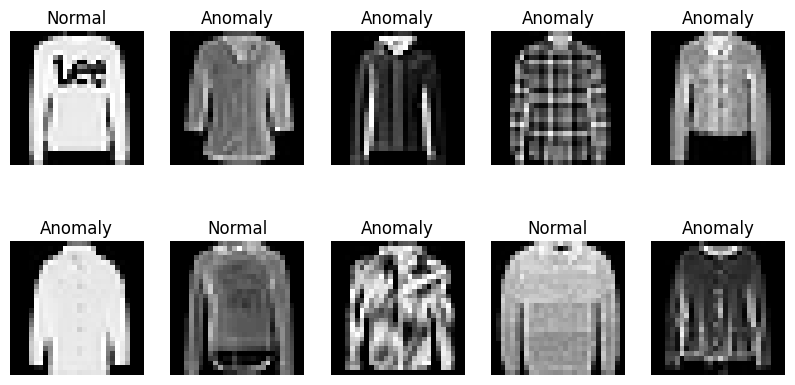

In [3]:
### data visualization
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.title(normalOrAnomaly(testset.targets[i].item()))
    plt.imshow(testset.data[i], cmap='gray')
plt.show()

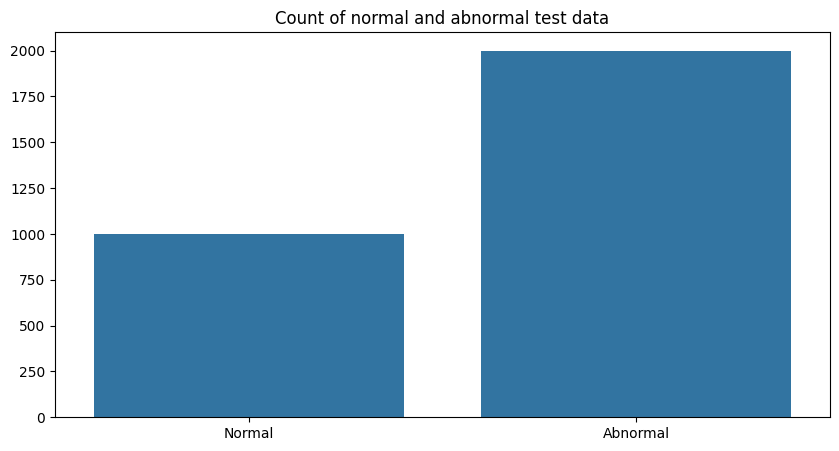

In [4]:
### 분포 보기 ab vs normal
import seaborn as sns
import pandas as pd

abnormal = (testset.targets != SELECT_NORMAL)
normal = (testset.targets == SELECT_NORMAL)

plt.figure(figsize=(10, 5))
plt.title('Count of normal and abnormal test data')

count_normal = normal.sum().item()
count_abnormal = abnormal.sum().item()

sns.barplot(x=['Normal', 'Abnormal'], y=[count_normal, count_abnormal])
plt.show()

### 테스트할 모델 불러오기 

In [5]:
from model.autoencoder import Autoencoder,Autoencoder2D
model = Autoencoder2D()
model.to(DEVICE)
model.load_state_dict(torch.load('./model_team8.pth'))
model.eval()

Autoencoder2D(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)

In [6]:
from torchsummary import summary

# Assuming the model is already loaded and named 'model'
# Also assuming the input size is (1, 28, 28) for FashionMNIST
x = next(iter(test_loader))[0].to(DEVICE)
# x = x.view(-1, 28*28).to(DEVICE)
summary(model, input_size=(x.shape[1], x.shape[2], x.shape[3]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 10, 10]             160
              ReLU-2           [-1, 16, 10, 10]               0
         MaxPool2d-3             [-1, 16, 5, 5]               0
            Conv2d-4              [-1, 8, 3, 3]           1,160
              ReLU-5              [-1, 8, 3, 3]               0
         MaxPool2d-6              [-1, 8, 2, 2]               0
   ConvTranspose2d-7             [-1, 16, 5, 5]           1,168
              ReLU-8             [-1, 16, 5, 5]               0
   ConvTranspose2d-9            [-1, 8, 15, 15]           3,208
             ReLU-10            [-1, 8, 15, 15]               0
  ConvTranspose2d-11            [-1, 1, 28, 28]              33
             Tanh-12            [-1, 1, 28, 28]               0
Total params: 5,729
Trainable params: 5,729
Non-trainable params: 0
-----------------------------------

### 성능 체크

In [7]:
# Test batch size should be 1 for this case.
THRESHOLDVAL=0.000005 # threshold value for anomaly detection
from torch.nn import functional as F
dic_loss = {'id':[], 'label':[], 'score':[],'normal':[]}
print(f'Start testing... for {len(test_loader)} data')
for step, (x, label) in enumerate(test_loader):
    x = x.to(DEVICE)
    output = model(x)
    loss = F.mse_loss(output, x, reduction='none').view(-1, 784).sum(dim=1)
    loss = loss = float(loss.cpu().detach().numpy().item())
    dic_loss['id'].append(step)
    dic_loss['label'].append(int(label==SELECT_NORMAL))
    dic_loss['score'].append(loss)
    # 0: anomaly, 1: normal (loss < threshold)
    dic_loss['normal'].append(int(loss<THRESHOLDVAL))


Start testing... for 3000 data


Text(-0.5, 1, 'Label')

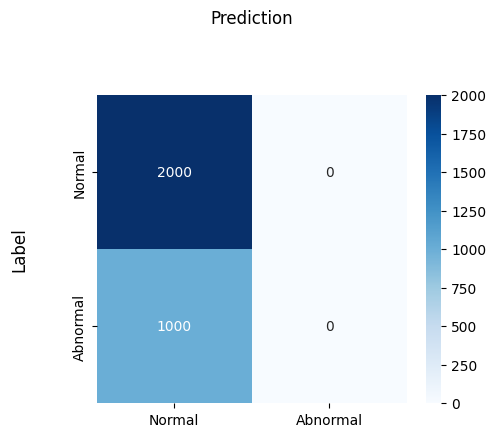

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
pred = dic_loss['normal'] # predicted label
label = dic_loss['label'] # actual label
# 0: anomaly, 1: normal로 change
cm = confusion_matrix(label, pred)
labels = ['Normal', 'Abnormal']

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

# x축, y축 제거
plt.xlabel("")
plt.ylabel("")

# ✅ 가운데 텍스트 추가
plt.text(1, -0.5, "Prediction", fontsize=12, ha='center', va='center')
plt.text(-0.5, 1, "Label", fontsize=12, rotation=90, ha='center', va='center')